In [130]:
# need to install uproot awkward, the rest is standard
# !pip install uproot awkward 

import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [131]:
file = uproot.open("TDHCAL_715480.root")
file.keys()

['DHCAL;1']

In [132]:
DHCAL = file['DHCAL']
DHCAL.keys()

['runNr',
 'eventNr',
 'triggerNr',
 'eventType',
 'beamEnergy',
 'Nhit',
 'DHCALEvent',
 'DHCALEvent/DHCALEvent.fUniqueID',
 'DHCALEvent/DHCALEvent.fBits',
 'DHCALEvent/DHCALEvent.fX',
 'DHCALEvent/DHCALEvent.fY',
 'DHCALEvent/DHCALEvent.fZ',
 'DHCALEvent/DHCALEvent.I',
 'DHCALEvent/DHCALEvent.J',
 'DHCALEvent/DHCALEvent.K',
 'DHCALEvent/DHCALEvent.fDif_id',
 'DHCALEvent/DHCALEvent.fAsic_id',
 'DHCALEvent/DHCALEvent.fChan_id',
 'DHCALEvent/DHCALEvent.fTime',
 'DHCALEvent/DHCALEvent.fThr']

In [133]:
df = DHCAL.arrays(library="ak")

In [134]:
df.fields

['runNr',
 'eventNr',
 'triggerNr',
 'eventType',
 'beamEnergy',
 'Nhit',
 'DHCALEvent',
 'DHCALEvent.fUniqueID',
 'DHCALEvent.fBits',
 'DHCALEvent.fX',
 'DHCALEvent.fY',
 'DHCALEvent.fZ',
 'DHCALEvent.I',
 'DHCALEvent.J',
 'DHCALEvent.K',
 'DHCALEvent.fDif_id',
 'DHCALEvent.fAsic_id',
 'DHCALEvent.fChan_id',
 'DHCALEvent.fTime',
 'DHCALEvent.fThr']

In [135]:
df["DHCALEvent.fX"][0]

<Array [97.9, 98.9, 77.1, 94.8, ..., 39.6, 40.6, 40.6] type='65 * float64'>

###  Showing Pions

These have hadronic interactions and yield large number of a hists in the detector. So, to select these events, we simply requires that the number of hits is large enough, $N_{hit}>500$ and this select hadronic showers. The low number of hits events are either cosmic muons or muons from the beam. You can see the difference by the angle of incidence. For refrence is the plots below the beam goes from the bottom-up.

Text(0.6, 0.8, 'Muons (cosmics + beam)')

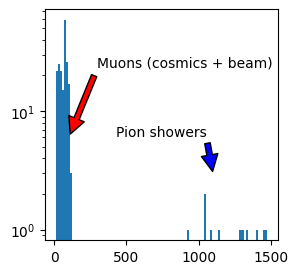

In [136]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(df.Nhit, bins=100)
ax.set_yscale("log")
ax.annotate('Pion showers',
            xy=(1100, 3), xycoords='data',
            xytext=(0.5, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

ax.annotate('Muons (cosmics + beam)',
            xy=(100, 6), xycoords='data',
            xytext=(0.6, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

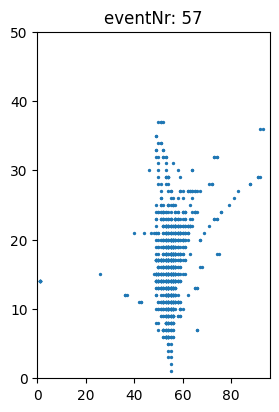

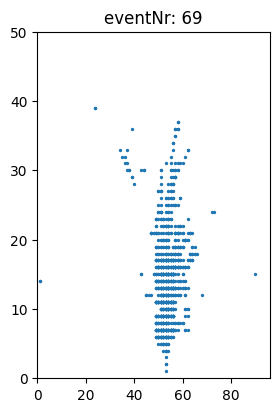

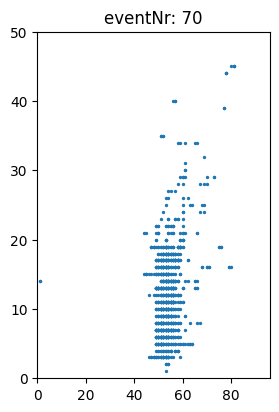

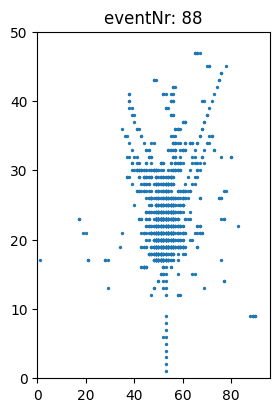

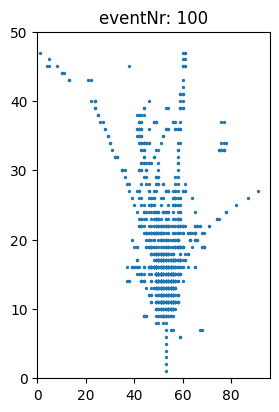

In [148]:
for event_id in range(5):
    plt.figure(figsize=(3,4.5))
    plt.title(f"eventNr: {df.eventNr[df.Nhit>500][event_id]}")
    plt.scatter(
        df["DHCALEvent.I"][df.Nhit>500][event_id], # I,J index in XY plane
        df["DHCALEvent.K"][df.Nhit>500][event_id], # K the depth index
        s = 2
        # c = df["DHCALEvent.fThr"][event_id]
    )
    
    plt.ylim([0, 50])
    plt.xlim([0, 96])

We can convert event data into a 3D numpy array image, with each layer having 96x96 channels and 50 layers of depth. The data includes positions (I, J) and depth (K). We can map the pixel positions (I, J) into layers and incorporate the depth (K) as the third axis. Since each layer has the same 96x96 spatial resolution, the final shape of the image should be (96, 96, 50), with K representing depth across the 50 layers.

In [142]:
# Dirty loop but works for small number of events
# Ideally can be done using dask
# The fianl product has the shape (batch_size, 96, 96, 50)
event_as_images = np.zeros((len(df), 96, 96, 50), dtype=np.int32)
for iev in range(len(df)):
    # define an empty image with shape (96, 96, 50)
    image = np.zeros((96, 96, 50), dtype=np.int32)
    
    # fill in the event
    I_array = ak.to_numpy(df["DHCALEvent.I"][iev])
    J_array = ak.to_numpy(df["DHCALEvent.J"][iev])
    K_array = ak.to_numpy(df["DHCALEvent.K"][iev])
    np.add.at(image, (I_array-1, J_array-1, K_array - 1), 1)
    event_as_images[iev] = image

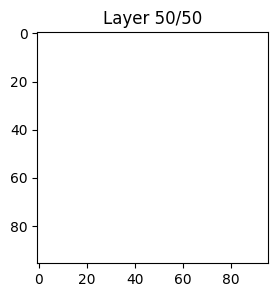

In [164]:
import matplotlib.animation as animation

# let look at event 57 (pion shower)
# Since the shower progresses inside the material 
# is akin to a time progression, let visualise this
shower_event_id = 57
frame0 = event_as_images[shower_event_id,:,:,0]


fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(frame0, interpolation=None, cmap="binary", animated=True)
ax.set_title("Layer 1/50")

def update(frame):
    im.set_array(event_as_images[shower_event_id,:,:,frame])
    ax.set_title(f"Layer {frame+1}/50")
    return [im]
    
ani = animation.FuncAnimation(
    fig, update, frames=image.shape[2],
    interval=200, blit=True
)
ani.save("shower_progression.gif", fps=5)